In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from Corpora import MovieReviewCorpus
from Lexicon import SentimentLexicon
from Statistics import SignTest
from Classifiers import NaiveBayesText, SVMText
from Extensions import SVMDoc2Vec

import numpy as np

In [15]:
# retrieve corpus
corpus=MovieReviewCorpus(stemming=False,pos=False)

# use sign test for all significance testing
signTest=SignTest()

print("--- classifying reviews using sentiment lexicon  ---")

# read in lexicon
lexicon=SentimentLexicon()

# on average there are more positive than negative words per review
# (~7.13 more positive than negative per review)
# to take this bias into account will use threshold (roughly the bias itself)
# to make it harder to classify as positive
threshold=8

# question 0.1
lexicon.classify(corpus.reviews,threshold,magnitude=False)
token_preds=lexicon.predictions
print(f"token-only results: {lexicon.getAccuracy():.2f}")

lexicon.classify(corpus.reviews,threshold,magnitude=True)
magnitude_preds=lexicon.predictions
print(f"magnitude results: {lexicon.getAccuracy():.2f}")

# question 0.2
p_value=signTest.getSignificance(token_preds,magnitude_preds)
significance = "significant" if p_value < 0.05 else "not significant"
print(f"magnitude lexicon results are {significance} with respect to token-only")

--- classifying reviews using sentiment lexicon  ---
token-only results: 0.67
magnitude results: 0.68
magnitude lexicon results are not significant with respect to token-only


In [4]:
# question 1.0
print("--- classifying reviews using Naive Bayes on held-out test set ---")
NB=NaiveBayesText(smoothing=False,bigrams=False,trigrams=False,discard_closed_class=False)
NB.train(corpus.train)
NB.test(corpus.test)
# store predictions from classifier
non_smoothed_preds=NB.predictions
print(f"Accuracy without smoothing: {NB.getAccuracy():.2f}")

--- classifying reviews using Naive Bayes on held-out test set ---
Accuracy without smoothing: 0.46


In [5]:
# question 2.0
# use smoothing
NB=NaiveBayesText(smoothing=True,bigrams=False,trigrams=False,discard_closed_class=False)
NB.train(corpus.train)
NB.test(corpus.test)
smoothed_preds=NB.predictions
# saving this for use later
num_non_stemmed_features=len(NB.vocabulary)
print(f"Accuracy using smoothing: {NB.getAccuracy():.2f}")


# question 2.1
# see if smoothing significantly improves results
p_value=signTest.getSignificance(non_smoothed_preds,smoothed_preds)
significance = "significant" if p_value < 0.05 else "not significant"
print(f"results using smoothing are {significance} with respect to no smoothing")

Accuracy using smoothing: 0.82
results using smoothing are significant with respect to no smoothing


In [6]:
# question 3.0
print("--- classifying reviews using 10-fold cross-evaluation ---")
# using previous instantiated object
NB.crossValidate(corpus)
# using cross-eval for smoothed predictions from now on
smoothed_preds=NB.predictions
print(f"Accuracy: {NB.getAccuracy():.3f}")
print(f"Std. Dev: {NB.getStdDeviation()}")

--- classifying reviews using 10-fold cross-evaluation ---
Accuracy: 0.810
Std. Dev: 0.020736441353327688


In [7]:
# question 4.0
print("--- stemming corpus ---")
# retrieve corpus with tokenized text and stemming (using porter)
stemmed_corpus=MovieReviewCorpus(stemming=True,pos=False)
print("--- cross-validating NB using stemming ---")
NB.crossValidate(stemmed_corpus)
stemmed_preds=NB.predictions
print(f"Accuracy: {NB.getAccuracy():.3f}")
print(f"Std. Dev: {NB.getStdDeviation():.3f}")

# TODO Q4.1
# see if stemming significantly improves results on smoothed NB
p_value=signTest.getSignificance(stemmed_preds,smoothed_preds)
significance = "significant" if p_value < 0.05 else "not significant"
print(f"results using stemming are {significance} with respect to non-stemmed corpus")

# TODO Q4.2
print("--- determining the number of features before/after stemming ---")
print("Number of features before stemming:", num_non_stemmed_features)
NB.train(stemmed_corpus.train)
print("Number of features after stemming:", len(NB.vocabulary))

--- stemming corpus ---
--- cross-validating NB using stemming ---
Accuracy: 0.814
Std. Dev: 0.026
results using stemming are not significant with respect to non-stemmed corpus
--- determining the number of features before/after stemming ---
Number of features before stemming: 52555
Number of features after stemming: 32404


In [8]:
# question Q5.0

# cross-validate model using smoothing and bigrams
print("--- cross-validating naive bayes using smoothing and bigrams ---")
NB=NaiveBayesText(smoothing=True,bigrams=True,trigrams=False,discard_closed_class=False)
NB.crossValidate(corpus)
smoothed_and_bigram_preds=NB.predictions
print(f"Accuracy: {NB.getAccuracy():.2f}") 
print(f"Std. Dev: {NB.getStdDeviation():.2f}")

# counting features using bigrams
NB.train(corpus.train)
num_bigram_features = len(NB.vocabulary)

# see if bigrams significantly improves results on smoothed NB only
p_value=signTest.getSignificance(smoothed_preds,smoothed_and_bigram_preds)
signifance = "significant" if p_value < 0.05 else "not significant"
print(f"results using smoothing and bigrams are {signifance} with respect to smoothing only")
print("--- cross-validating naive bayes using smoothing and trigrams ---")
NB=NaiveBayesText(smoothing=True,bigrams=False,trigrams=True,discard_closed_class=False)
NB.crossValidate(corpus)
smoothed_and_trigram_preds=NB.predictions
print(f"Accuracy: {NB.getAccuracy():.2f}") 
print(f"Std. Dev: {NB.getStdDeviation():.2f}")

# counting features using trigrams
NB.train(corpus.train)
num_trigram_features = len(NB.vocabulary)

# see if bigrams significantly improves results on smoothed NB only
p_value=signTest.getSignificance(smoothed_preds,smoothed_and_trigram_preds)
signifance = "significant" if p_value < 0.05 else "not significant"
print(f"results using smoothing and trigrams are {signifance} with respect to smoothing only")

# TODO Q5.1
print("--- determining the number of features before/after using bigrams ---")
print("Number of features before using bigrams (Q3):", num_non_stemmed_features)
print("Number of features after using bigrams:", num_bigram_features)
print("Number of features after using trigrams:", num_trigram_features)

--- cross-validating naive bayes using smoothing and bigrams ---
Accuracy: 0.76
Std. Dev: 0.02
results using smoothing and bigrams are significant with respect to smoothing only
--- cross-validating naive bayes using smoothing and trigrams ---
Accuracy: 0.70
Std. Dev: 0.03
results using smoothing and trigrams are significant with respect to smoothing only
--- determining the number of features before/after using bigrams ---
Number of features before using bigrams (Q3): 52555
Number of features after using bigrams: 500086
Number of features after using trigrams: 1015074


In [11]:
# TODO Q6 and 6.1

# retrieve corpus
corpus=MovieReviewCorpus(stemming=False,pos=False)

print("--- classifying reviews using SVM 10-fold cross-eval ---")
SVM=SVMText(bigrams=False,trigrams=False,discard_closed_class=False)
SVM.crossValidate(corpus)
svm_preds=SVM.predictions
print(f"Accuracy: {SVM.getAccuracy():.4f}") 
print(f"Std. Dev: {SVM.getStdDeviation():.3f}")

# see if stemming significantly improves results on smoothed NB
p_value=signTest.getSignificance(svm_preds, smoothed_preds)
significance = "significant" if p_value < 0.05 else "not significant"
print(f"results using SVMs are {significance} with respect to smoothed Naive-Bayes")

--- classifying reviews using SVM 10-fold cross-eval ---
Accuracy: 0.8380
Std. Dev: 0.020
results using SVMs are not significant with respect to smoothed Naive-Bayes


In [12]:
# TODO Q7

print("--- adding in POS information to corpus ---")
# retrieve corpus with POS information
corpus_pos = MovieReviewCorpus(stemming=False,pos=True)

print("--- training svm on word+pos features ----")
SVM=SVMText(bigrams=False,trigrams=False,discard_closed_class=False)
SVM.crossValidate(corpus_pos)
svm_wordpos_preds = SVM.predictions
print(f"Accuracy: {SVM.getAccuracy():.4f}") 
print(f"Std. Dev: {SVM.getStdDeviation():.3f}")

# see if stemming significantly improves results on smoothed NB
p_value=signTest.getSignificance(svm_wordpos_preds, smoothed_preds)
significance = "significant" if p_value < 0.05 else "not significant"
print(f"results using Word+POS features with SVMs are {significance} with respect to smoothed Naive-Bayes")

print("--- training svm discarding closed-class words ---")
SVM_dcc=SVMText(bigrams=False,trigrams=False,discard_closed_class=True)
SVM_dcc.crossValidate(corpus_pos)
svm_dcc_preds = SVM_dcc.predictions 
print(f"Accuracy: {SVM_dcc.getAccuracy():.4f}") 
print(f"Std. Dev: {SVM_dcc.getStdDeviation():.3f}")

# see if stemming significantly improves results on smoothed NB
p_value=signTest.getSignificance(svm_dcc_preds, smoothed_preds)
significance = "significant" if p_value < 0.05 else "not significant"
print(f"results discarding all closed-class words are {significance} with respect to smoothed Naive-Bayes")

--- adding in POS information to corpus ---
--- training svm on word+pos features ----
Accuracy: 0.8345
Std. Dev: 0.026
results using Word+POS features with SVMs are not significant with respect to smoothed Naive-Bayes
--- training svm discarding closed-class words ---
Accuracy: 0.8360
Std. Dev: 0.023
results discarding all closed-class words are not significant with respect to smoothed Naive-Bayes


## Question 8 (40% of the marks)

In [3]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import tensorflow as tf

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [5]:
print("--- reading dataset from keras.datasets ---")
imdb = tf.keras.datasets.imdb
(train_reviews, train_labels), (test_reviews, test_labels) = imdb.load_data()

print("--- getting vocabulary ---")
vocab_word_to_id = imdb.get_word_index()
vocab_word_to_id = {word:(word_id + 3) for word, word_id in vocab_word_to_id.items()}
vocab_word_to_id["<PAD>"] = 0
vocab_word_to_id["<START>"] = 1
vocab_word_to_id["<UNK>"] = 2
vocab_word_to_id["<UNUSED>"] = 3

vocab_id_to_word =  dict([(value, key) for (key, value) in vocab_word_to_id.items()])

--- reading dataset from keras.datasets ---
--- getting vocabulary ---


In [6]:
def decode_int_review(int_review):
    return [vocab_id_to_word.get(id, "?") for id in int_review]

In [7]:
print("--- concatenating train and test reviews to infer their embeddings at once ---")
reviews = np.concatenate((train_reviews, test_reviews))

print("--- creating documents after decoding reviews ---")
docs = [TaggedDocument(decode_int_review(int_review), [i]) for i, int_review in enumerate(reviews)]

--- concatenating train and test reviews to infer their embeddings at once ---
--- creating documents after decoding reviews ---


In [27]:
MODEL_STORE_PATH = "./doc2vec_models/"
base_model_name = "D2V_model_"

# distributed memory of distributed bag of words
for dm in [1,0]:
    if dm: dm_model_name = base_model_name+"dm_"
    else: dm_model_name = base_model_name+"dbow_"

    # hierarchical softmax or negative sampling
    for hs in [1,0]:
        if hs:
            hs_model_name = dm_model_name+"hs_"
            neg = 0
        else:
            hs_model_name = dm_model_name+"ns_"
            neg = 5
        
        # ignores all words with total frequency lower than this
        for min_count in [1, 2, 5]:
            mc_model_name = hs_model_name+"mc"+str(min_count)

            # embeddings vector size
            for vec_size in [50, 100]:
                model_name = mc_model_name+"_vs"+str(vec_size)+".model"

                print("======> Training: ", model_name)
                d2v_model = Doc2Vec(docs, dm=dm, min_count=min_count, vector_size=vec_size,
                                    hs=hs, negative=neg, epochs=60, sample=0)
                
                # storing model
                d2v_model.save(MODEL_STORE_PATH+model_name)

                # getting embeddings
                embeddings = d2v_model.dv.get_normed_vectors()
                train_embeddings, test_embeddings = np.split(embeddings, [25000])

                # training + testing using a SVM
                SVMD2V = SVMDoc2Vec()
                SVMD2V.train(train_embeddings, train_labels)
                SVMD2V.test(test_embeddings, test_labels)
                # results
                acc = SVMD2V.getAccuracy()
                stdev = SVMD2V.getStdDeviation()

                print("Results of", model_name, "Acc:", acc, "+-", stdev)

======> Training:  D2V_model_dm_hs_mc1_vs50.model
Results of D2V_model_dm_hs_mc1_vs50.model Acc: 0.80716 +- 0.0045622801316885335
======> Training:  D2V_model_dm_hs_mc1_vs100.model
Results of D2V_model_dm_hs_mc1_vs100.model Acc: 0.81372 +- 0.007193441457327658
======> Training:  D2V_model_dm_hs_mc2_vs50.model
Results of D2V_model_dm_hs_mc2_vs50.model Acc: 0.79656 +- 0.004999839997439939
======> Training:  D2V_model_dm_hs_mc2_vs100.model
Results of D2V_model_dm_hs_mc2_vs100.model Acc: 0.8126 +- 0.00466218832738446
======> Training:  D2V_model_dm_hs_mc5_vs50.model
Results of D2V_model_dm_hs_mc5_vs50.model Acc: 0.79604 +- 0.004455827644781613
======> Training:  D2V_model_dm_hs_mc5_vs100.model
Results of D2V_model_dm_hs_mc5_vs100.model Acc: 0.80988 +- 0.005924997890294991
======> Training:  D2V_model_dm_ns_mc1_vs50.model
Results of D2V_model_dm_ns_mc1_vs50.model Acc: 0.8386 +- 0.005411838874172068
======> Training:  D2V_model_dm_ns_mc1_vs100.model
Results of D2V_model_dm_ns_mc1_vs100.model

### **Do NOT executing next cell** (unless you are sure)

In [45]:
# question 8.0
print("--- pre-training doc2vec model ---")
d2v_model = Doc2Vec(docs, dm=0, min_count=2, vector_size=100, hs=0, negative=5, epochs=100, sample=0)

--- pre-training doc2vec model ---


In [6]:
fmodel_name = "doc2vec_models/d2v_model.model"

In [47]:
d2v_model.save(fmodel_name)

In [8]:
d2v_model = Doc2Vec.load("doc2vec_models/d2v_model.model")

In [9]:
print("--- extracting learned embeddings and splitting them into training and testing sets")
embeddings = d2v_model.dv.get_normed_vectors()
train_embeddings, test_embeddings = np.split(embeddings, [25000]) # 25K because we have 25K reviews for training and 25K for testing

print("training shape:", train_embeddings.shape)
print("testing shape:", test_embeddings.shape)

--- extracting learned embeddings and splitting them into training and testing sets
training shape: (25000, 100)
testing shape: (25000, 100)


In [17]:
print("--- using document embeddings ---")

SVMD2V = SVMDoc2Vec()
SVMD2V.train(train_embeddings, train_labels)
SVMD2V.test(test_embeddings, test_labels)

SVM_doc2vec_preds = SVMD2V.pred_labels

print(f"Accuracy: {SVMD2V.getAccuracy():.2f}") 
print(f"Std. Dev: {SVMD2V.getStdDeviation():.2f}")

--- using document embeddings ---
Accuracy: 0.90
Std. Dev: 0.01


#### Naive-Bayes on IMDB

In [11]:
train_docs, test_docs = np.split(docs, [25000])

print(train_docs.shape, test_docs.shape)

(25000, 2) (25000, 2)


/usr/local/lib/python3.9/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [12]:
train_reviews = []
for i,doc in enumerate(train_docs):
    actual_doc = doc[0]
    if train_labels[i]==1:
        lbl = "POS"
    else:
        lbl = "NEG"
    train_reviews.append((lbl, actual_doc))

print(len(train_reviews))

test_reviews = []
for i,doc in enumerate(test_docs):
    actual_doc = doc[0]
    if test_labels[i]==1:
        lbl = "POS"
    else:
        lbl = "NEG"
    test_reviews.append((lbl, actual_doc))

print(len(test_reviews))


25000
25000


In [13]:
NB_doc2vec = NaiveBayesText(smoothing=True,bigrams=False,trigrams=False,discard_closed_class=False)
NB_doc2vec.train(train_reviews)
NB_doc2vec.test(test_reviews)
NB_doc2vec_preds=NB_doc2vec.predictions
print(f"Accuracy: {NB_doc2vec.getAccuracy():.4f}") 
print(f"Std. Dev: {NB_doc2vec.getStdDeviation():.3f}")

Accuracy: 0.8133
Std. Dev: 0.009


In [18]:
p_value=signTest.getSignificance(NB_doc2vec_preds, SVM_doc2vec_preds)
significance = "significant" if p_value < 0.05 else "not significant"
print(f"results using Doc2Vec-Naive-Bayes are {significance} with respect to Doc2Vec-SVM")

results using Doc2Vec-Naive-Bayes are significant with respect to Doc2Vec-SVM


#### Visualizing embeddings

In [30]:
import pylab
from tsne import *
import matplotlib.pyplot as plt

In [33]:
# Just visualizing 3000 training embeddings
n_embed = 3000
Y = tsne(train_embeddings[:n_embed,:], 2, 100, 20.0)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 3000...
Computing P-values for point 500 of 3000...
Computing P-values for point 1000 of 3000...
Computing P-values for point 1500 of 3000...
Computing P-values for point 2000 of 3000...
Computing P-values for point 2500 of 3000...
Mean value of sigma: 0.208208
Iteration 100: error is 25.154181
Iteration 200: error is 3.517170
Iteration 300: error is 3.206510
Iteration 400: error is 3.086913
Iteration 500: error is 3.026528
Iteration 600: error is 2.991015
Iteration 700: error is 2.968521
Iteration 800: error is 2.953601
Iteration 900: error is 2.943243
Iteration 1000: error is 2.936134


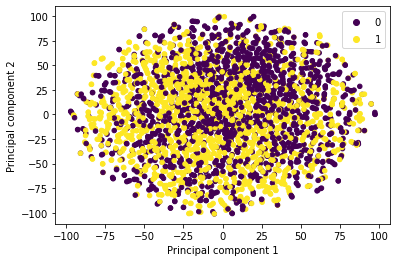

In [27]:
ax = pylab.scatter(Y[:, 0], Y[:, 1], 20, train_labels[:n_embed])
pylab.xlabel("Principal component 1")
pylab.ylabel("Principal component 2")
pylab.legend(*ax.legend_elements(num=1))
pylab.show()

In [ ]:
for i in range(n_embed):
    if Y[i,0] > -80 and Y[i,0] < -70:
        if Y[i,1] > -25 and Y[i,1] < 0:
            print(i)

In [ ]:
def plot_ids(ids):
    pylab.scatter(Y[:, 0], Y[:, 1], 20, test_labels[:n_embed], alpha=0.15, s=200)
    for id in ids:
        pylab.scatter(Y[id, 0], Y[id, 1], 20, label="doc id="+str(id))
    pylab.legend()
    pylab.show()

In [ ]:
ids = [84, 1791, 470]
plot_ids(ids)

In [28]:
pred_labels[:n_embed] 

neg_indices = (test_labels[:n_embed] == 0)
pos_indices = (test_labels[:n_embed] == 1)

true_positive = (test_labels[:n_embed]  == 1) * (pred_labels[:n_embed] == 1)
true_negative = (test_labels[:n_embed]  == 0) * (pred_labels[:n_embed] == 0)
false_positive = (test_labels[:n_embed]  == 0) * (pred_labels[:n_embed] == 1)
false_negative = (test_labels[:n_embed]  == 1) * (pred_labels[:n_embed] == 0)

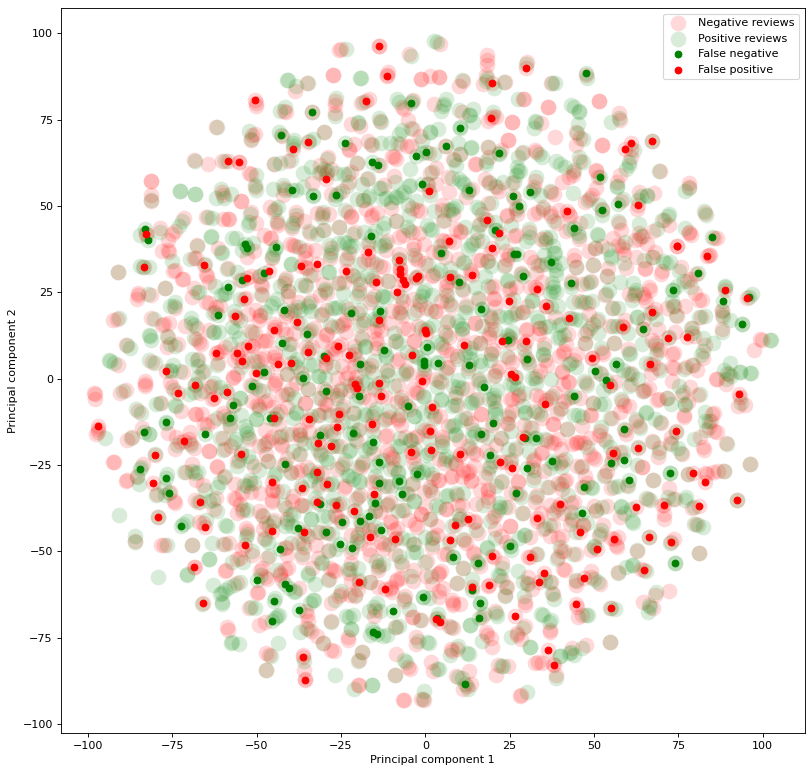

In [34]:
fig = plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')


plt.scatter(Y[neg_indices][:, 0], Y[neg_indices][:, 1], c='r', alpha=0.15, s=200, lw = 0,label="Negative reviews")
plt.scatter(Y[pos_indices][:, 0], Y[pos_indices][:, 1], c='g', alpha=0.15, s=200, lw = 0, label="Positive reviews")

plt.scatter(Y[false_negative][:, 0], Y[false_negative][:, 1], c='g', label="False negative")
plt.scatter(Y[false_positive][:, 0], Y[false_positive][:, 1], c='r', label="False positive")

plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")
plt.legend()
plt.show()

In [ ]:
bad_pred_indices = false_positive + false_negative
good_pred_indices = true_positive + true_negatice

In [ ]:
# Just visualizing 3000 testing embeddings in 3d
n_embed = 3000
Y3d = tsne(test_embeddings[:n_embed,:], 3, 100, 20.0)

In [ ]:
fig = plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection='3d')

ax.scatter(reduced_data_3d[neg_indices][:, 0], reduced_data_3d[neg_indices][:, 1], reduced_data_3d[neg_indices][:, 2], c='r', alpha=0.2, label="Negative reviews")
ax.scatter(reduced_data_3d[pos_indices][:, 0], reduced_data_3d[pos_indices][:, 1], reduced_data_3d[pos_indices][:, 2], c='g', alpha=0.2, label="Positive reviews")

ax.scatter(reduced_data_3d[-200:][bad_pred_indices][:, 0], reduced_data_3d[-200:][bad_pred_indices][:, 1], reduced_data_3d[-200:][bad_pred_indices][:, 2], c='k', label="Misclassified points")

plt.legend()
plt.show()